# Notebook para inferência do DETR com SROIE

In [1]:
import sys                                                                                                                                                                                                      
import yaml                                                                                                                                                                                                     
from argparse import Namespace                                                                                                                                                                                  
import glob

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision

In [2]:
# sys.path.append('../src')      # did not work (maybe a conflict with another util?)                                                                                                                            
sys.path.insert(0, '../src')

In [3]:
from main_lightning import LitDETR

## Carrega hiperparâmetros do arquivo config usado para o experimento atual

In [4]:
config_path = '../src/my_hparams.yaml'
data_path = '../data/processed/0325updated.task1train(626p)/'
ckpt_path = glob.glob('../lightning_logs/version_0/checkpoints/*ckpt')[0]

In [5]:
hparams = yaml.load(open(config_path), Loader=yaml.FullLoader)

# the original key is no_aux_loss
# hparams.pop('aux_loss', None) 
hparams['aux_loss'] = True

# Not necessary to load coco-trained parameters
hparams['resume'] = ''

# update dataset path
hparams[ 'dataset_path'] = data_path

hparams[ 'gpus'] = 0

In [6]:
print(hparams)

{'num_classes': 1, 'backbone': 'resnet50', 'dilation': True, 'position_embedding': 'sine', 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 100, 'pre_norm': False, 'masks': False, 'no_aux_loss': False, 'set_cost_class': 1.5, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'mask_loss_coef': 1, 'dice_loss_coef': 1.5, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coef': 0.1, 'lr': 1e-05, 'lr_backbone': 1e-06, 'batch_size': 5, 'weight_decay': 0.0001, 'lr_drop': 40, 'dataset_file': 'sroie', 'dataset_path': '../data/processed/0325updated.task1train(626p)/', 'remove_difficult': False, 'seed': 29062020, 'resume': '', 'num_workers': 8, 'gpus': 0, 'num_nodes': 1, 'num_processes': 1, 'max_epochs': 100, 'min_epochs': 1, 'accumulate_grad_batches': 7, 'amp_level': 'O2', 'precision': 32, 'auto_select_gpus': False, 'benchmark': True, 'check_val_every_n_epoch': 1, 'checkpoint_callback': True, 'deterministic': False, 'early_stop_callback'

## Carrega checkpoint resultante do experimento atual

In [7]:
checkpoint_path = glob.glob(ckpt_path)[0]
print(f'Checkpoint: {checkpoint_path}')                                                                                                                     
checkpoint = torch.load(checkpoint_path,map_location='cpu')

Checkpoint: ../lightning_logs/version_0/checkpoints/epoch=20.ckpt


## Define o model

In [8]:
hparams=Namespace(**hparams)                    
                                                
model = LitDETR(hparams)
model.eval()

LitDETR(
  (model): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=

In [9]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Carrega dados de teste

In [10]:
model.prepare_data()
dataloader = model.test_dataloader()

In [11]:
batch, labels = next(iter(dataloader))
imgs, _ = batch.decompose()

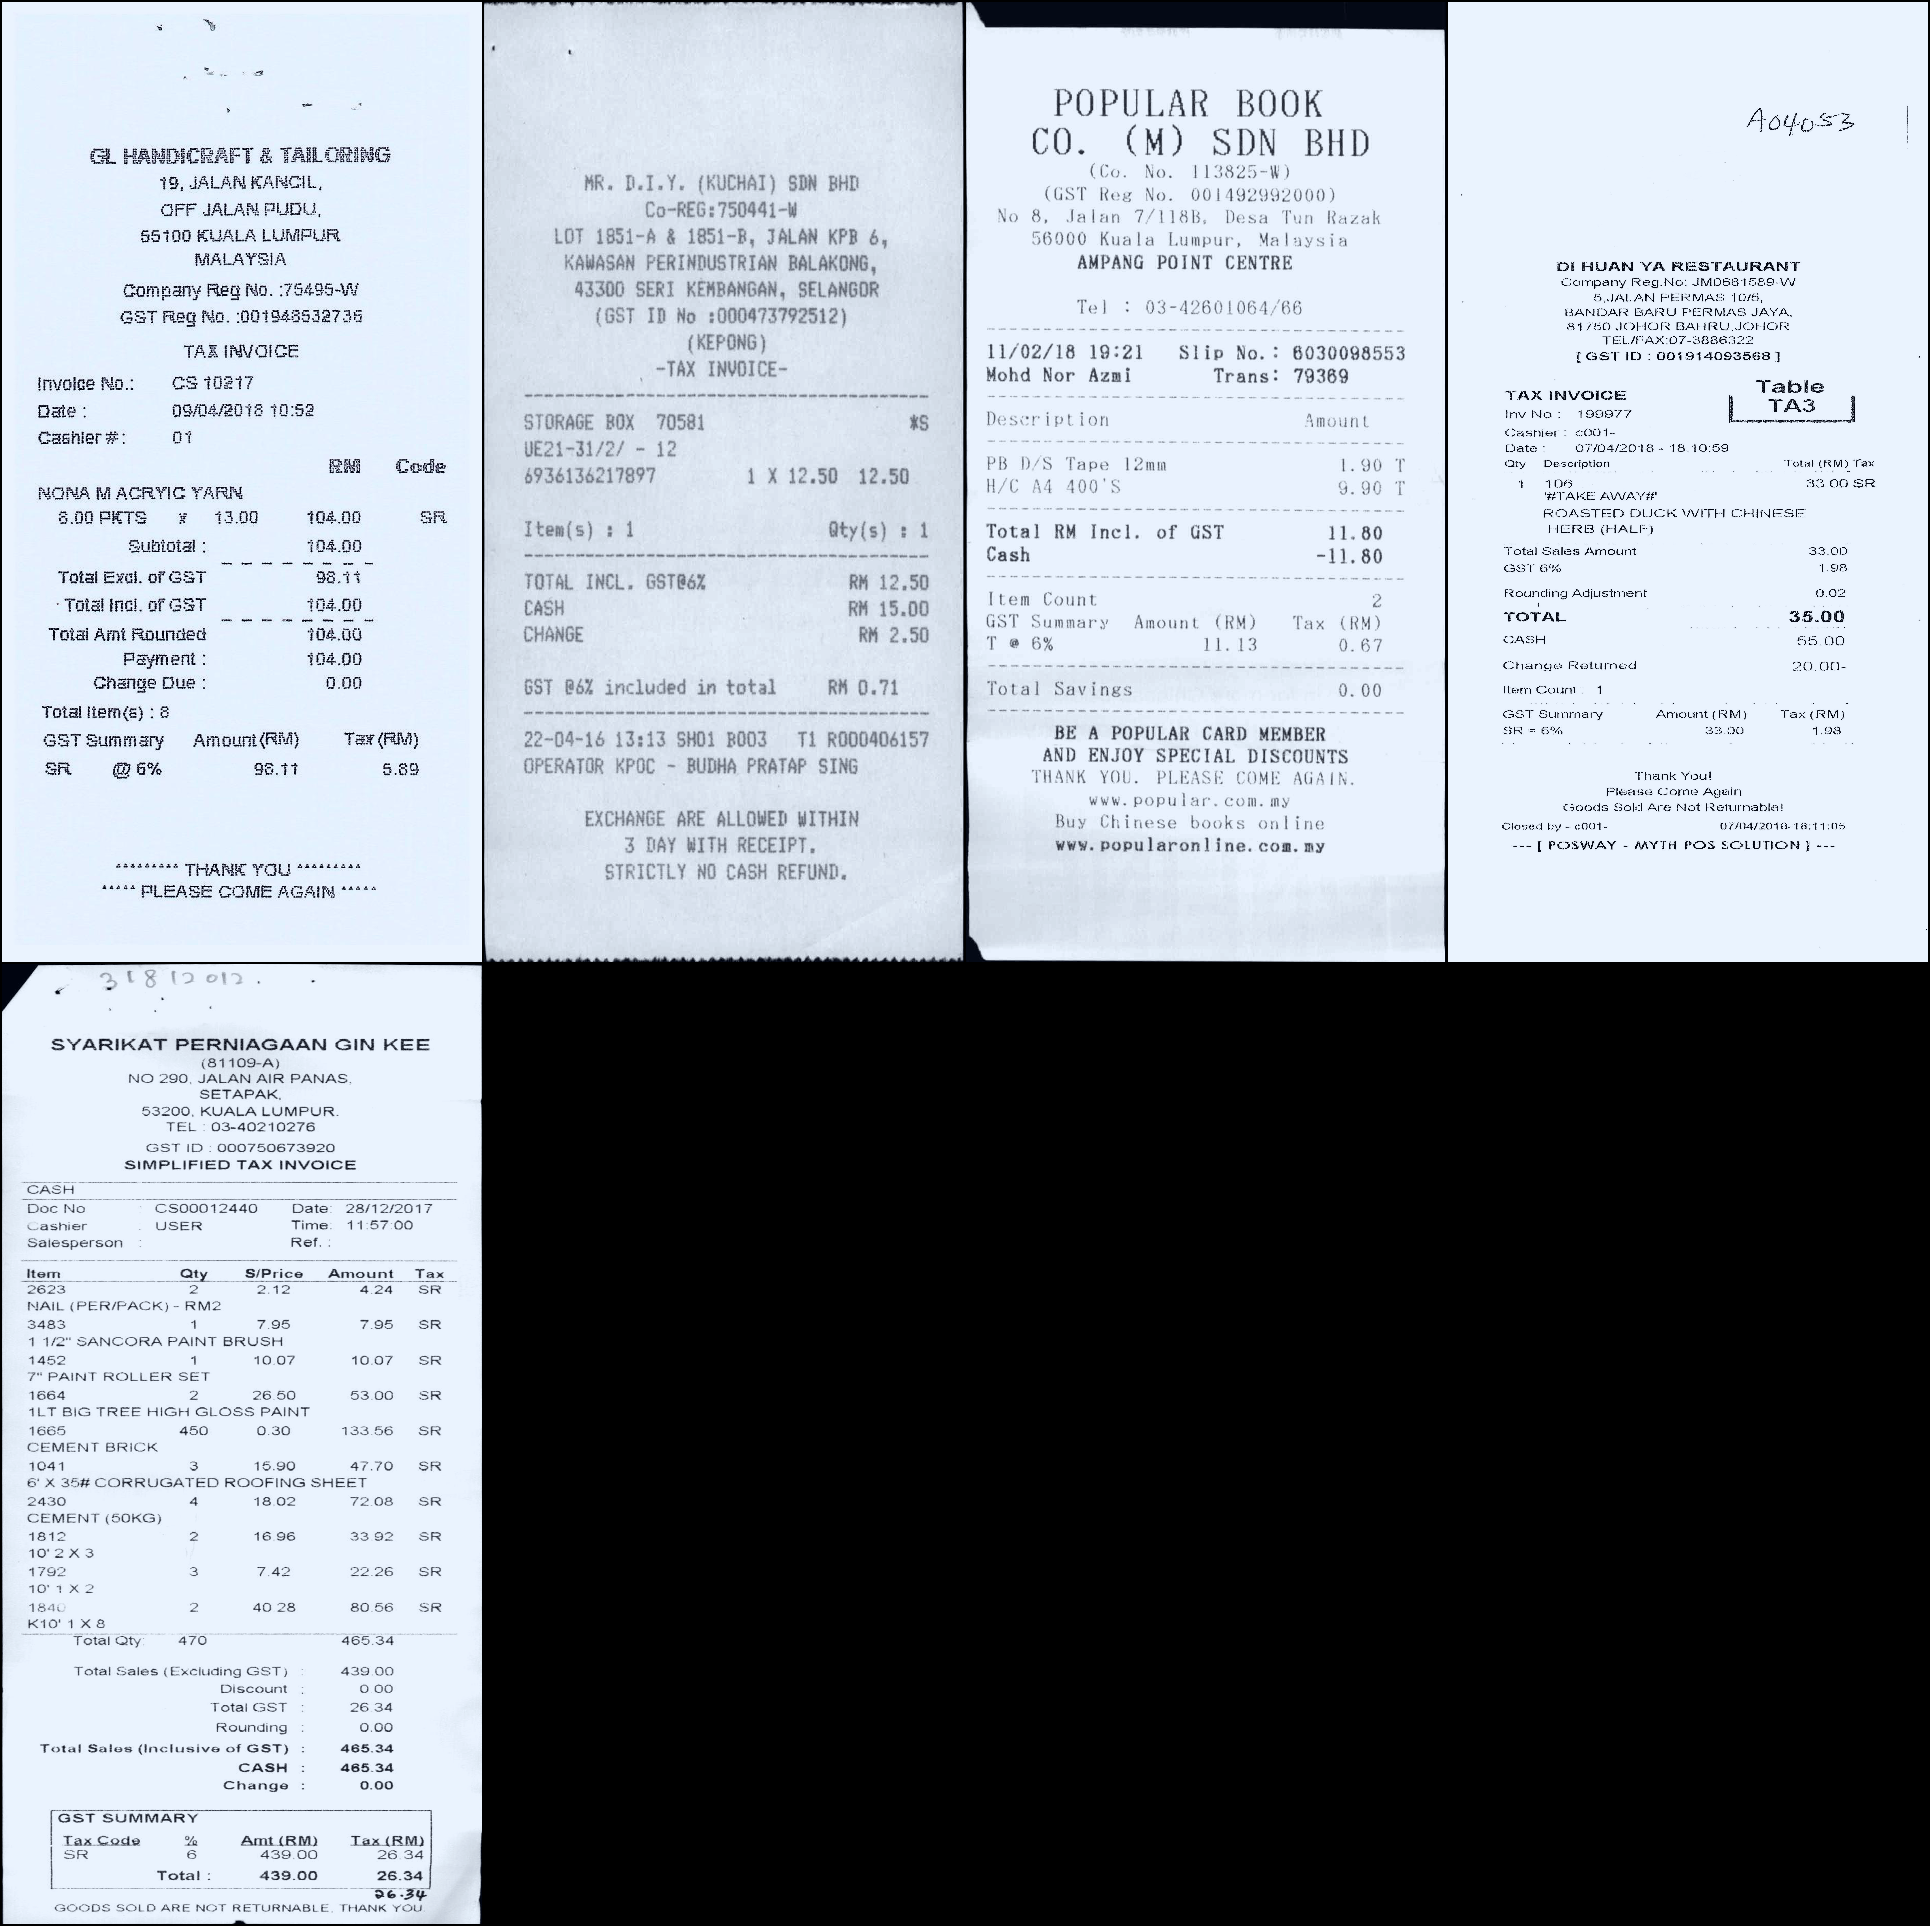

In [12]:
grid = torchvision.utils.make_grid(imgs, nrow=4, padding=2, normalize=True)
torchvision.transforms.ToPILImage()(grid)

## Funções de predição e Plotagem

In [13]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [14]:
def detect(im, model):
    
    # propagate through the model
    outputs = model(im)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1] # ramon: -1 to remove the "no object" class prediction
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep].cpu(), (im.size()[-1], im.size()[-2]))  # im as tensor (bs, ch, h, w )
    
    return probas[keep], bboxes_scaled

In [15]:
CLASSES = ['text']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #cl = p.argmax()
        #text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        #ax.text(xmin, ymin, text, fontsize=15,
        #        bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Predição

In [37]:
idx = 3
img_tensor = imgs[idx]
target_boxes = labels[idx]['boxes']
im = img_tensor.permute(1,2,0) * model.dataset_train.std + model.dataset_train.mean
img = torchvision.transforms.ToPILImage()(im.permute(2,0,1))

In [38]:
scores, boxes = detect(img_tensor.unsqueeze(0), model)

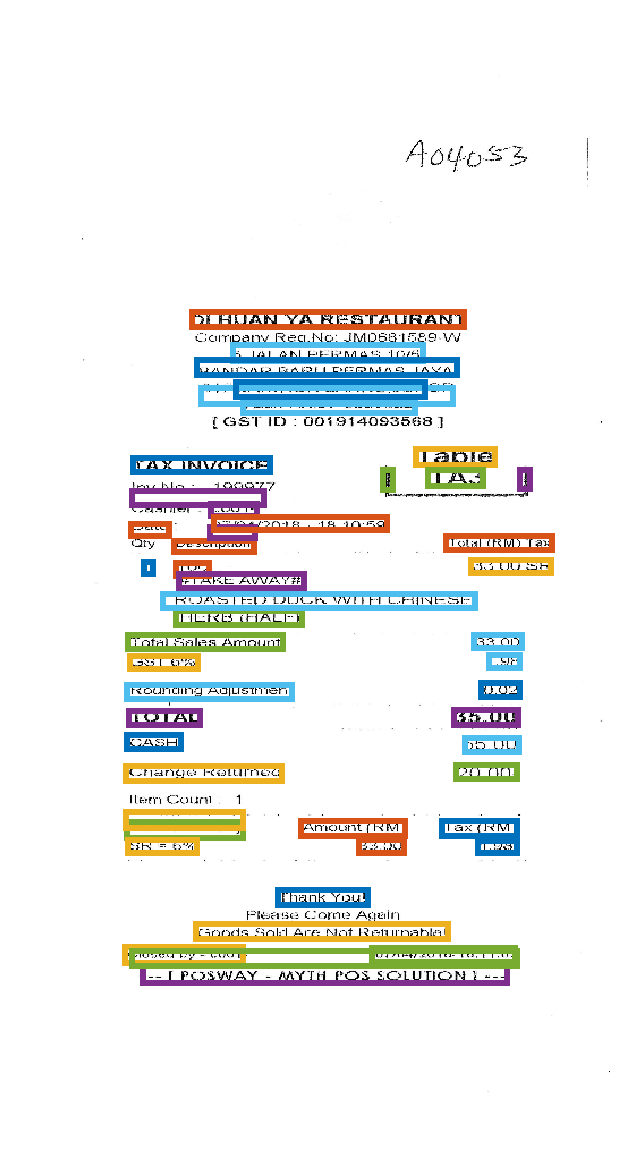

In [39]:
# Plotting predictions
plot_results(img, scores, boxes)

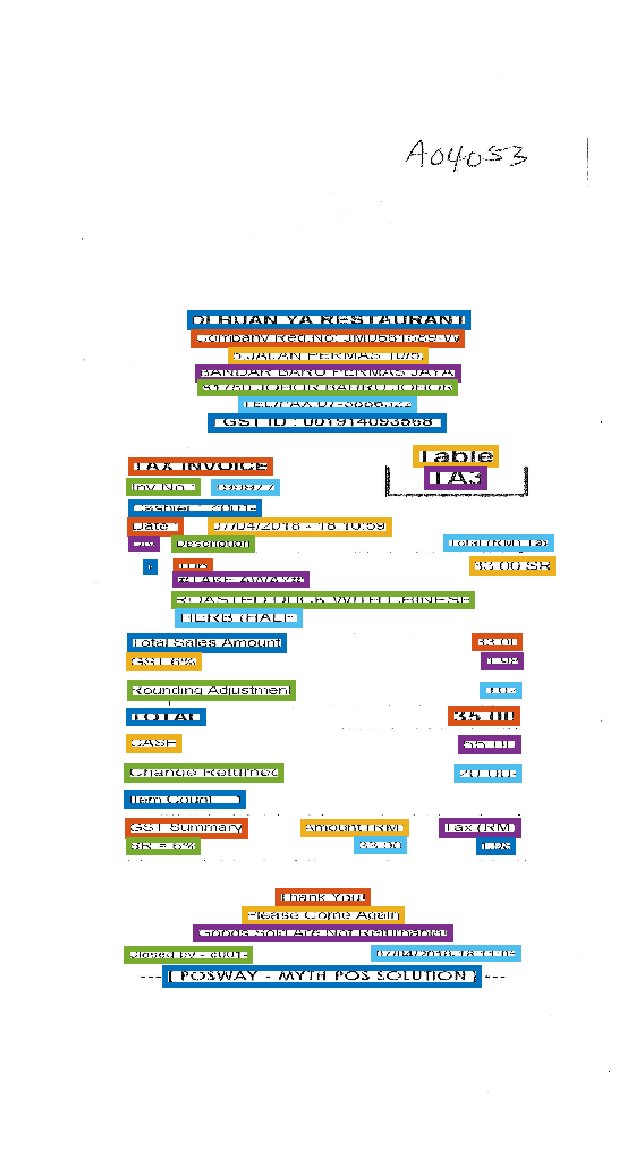

In [41]:
# Plotting targets
plot_results(img, scores, rescale_bboxes(target_boxes, img.size)) # visualize targets